In [1]:
# # Install requered libraries if needed
# !pip install toml --user
# !pip install segmentation-models --user
# !pip install gitpython --user

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sys


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# fix seed
sys.path.append('../..')
import utils.seed

# fix seed one more time
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Using TensorFlow backend.


In [2]:
# external imports
import numpy as np
import json
import toml
import hashlib
import argparse
import pandas as pd
import shutil 
import keras
from keras.models import Model
from keras import layers
from keras.optimizers import Adam

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

from torch.utils.data import WeightedRandomSampler

In [3]:
from utils.datasets import ShipSegmentationDataset, make_transform, to_dict
from utils.augmenters import get_augmenter
from utils.samplers import get_sampler
from utils.reproduce import save_commit_hash, save_config
from utils.transforms import get_transforms

In [4]:
# import importlib
# importlib.reload(keras_backend)

In [5]:
import keras_backend
from keras_backend.generators import segmentation_generator
from keras_backend.callbacks import get_callbacks
from keras_backend.losses import get_losses
from keras_backend.metrics import get_metrics

In [6]:
# read pipeline configuration file
CONFIG_PATH = 'config_3.toml'
config = toml.load(CONFIG_PATH)

In [7]:
config

{'augmentation': {'Flip': {'p': 0.75},
  'JpegCompression': {'p': 0.05, 'quality_lower': 60, 'quality_upper': 100},
  'OneOf_1': {'CLAHE': {'clip_limit': 4.0, 'p': 1.0},
   'RandomBrightness': {'limit': 0.1, 'p': 1.0},
   'RandomContrast': {'limit': 0.1, 'p': 1.0},
   'RandomGamma': {'gamma_limit': [80, 120], 'p': 1.0},
   'p': 0.3},
  'OneOf_2': {'HueSaturationValue': {'hue_shift_limit': 5,
    'p': 1.0,
    'sat_shift_limit': 5,
    'val_shift_limit': 5},
   'RGBShift': {'b_shift_limit': 15,
    'g_shift_limit': 7,
    'p': 1.0,
    'r_shift_limit': 7},
   'p': 0.3},
  'RandomRotate90': {'p': 0.75},
  'ShiftScaleRotate': {'p': 0.5,
   'rotate_limit': 45.0,
   'scale_limit': 0.3,
   'shift_limit': 0},
  'Transpose': {'p': 0.5}},
 'callbacks': {'MultiGPUModelCheckpoint': {'filepath': 'model-{val_iou_score:.5}.h5',
   'mode': 'max',
   'monitor': 'val_iou_score',
   'save_best_only': True,
   'save_weights_only': False,
   'verbose': 1},
  'ScheduledLR': {'factor': 0.3, 'milestones': [4

In [8]:
# define data transform parameters such as augmentation and preprocessing
augmenter = get_augmenter(config['augmentation'])
preprocessing_fn = get_preprocessing(config['model']['backbone'])
transforms = get_transforms(**config.get('transforms', []))

train_transform = make_transform(augmenter=augmenter, preprocessing_fn=preprocessing_fn, transforms=transforms)
valid_transform = make_transform(preprocessing_fn=preprocessing_fn)

In [9]:
# read train data and split for oout of fold validation
masks_df = pd.read_csv(config['data']['masks_csv'])
folds_df = pd.read_csv(config['data']['folds_csv'])

df = pd.merge(folds_df, masks_df, on='ImageId')

train_df = df[df['fold'] != config['training']['oof']].drop('fold', axis=1)
valid_df = df[df['fold'] == config['training']['oof']].drop('fold', axis=1)

# convert dataframes to dict for fast masks search
train_dict = to_dict(train_df)
valid_dict = to_dict(valid_df)

Indexing... ETA - 14.5857 sec.
Indexing... ETA - 3.6815 sec.


In [10]:
train_ids = list(train_dict.keys())
valid_ids = list(valid_dict.keys())

In [11]:
#prepare samplers (with different ratio)
# train sampler 
train_labels = np.array([1 if train_dict[id][0] else 0 for id in train_ids])
## calculate number of samples in whole traning process
train_n_samples = (config['training']['train_batch_size'] * config['training']['train_steps'] * 
                  (config['training']['epoch_end'] - config['training']['epoch_start'] + 2))
print(train_n_samples)

TrainSampler = get_sampler(config['sampling']['train']['strategy'])
train_sampler = TrainSampler(train_labels, config['sampling']['train']['params'], n_samples=train_n_samples)


#prepare samplers (with different ratio)

# # valid sampler
valid_labels = np.array([1 if valid_dict[id][0] else 0 for id in valid_ids])
## calculate number of samples in whole validation process
valid_n_samples = (config['training']['valid_batch_size'] * config['training']['valid_steps'] * 
                  (config['training']['epoch_end'] - config['training']['epoch_start'] + 2))
print(valid_n_samples)

ValidSampler = get_sampler(config['sampling']['valid']['strategy'])
valid_sampler = ValidSampler(valid_labels, config['sampling']['valid']['params'], n_samples=valid_n_samples)

3264000
408000


In [12]:
# define datasets and data generators
train_dataset = ShipSegmentationDataset(train_ids, config['data']['train'], 
                                        masks_df=train_dict, transform=train_transform)

valid_dataset = ShipSegmentationDataset(valid_ids, config['data']['train'], 
                                        masks_df=valid_dict, transform=valid_transform)


train_gen = segmentation_generator(dataset=train_dataset, 
                                   batch_size=config['training']['train_batch_size'],
                                   sampler=train_sampler,
                                   num_workers=16)

valid_gen = segmentation_generator(dataset=valid_dataset, 
                                   batch_size=config['training']['valid_batch_size'],
                                   sampler=valid_sampler,
                                   num_workers=4)

In [13]:
# import matplotlib.pyplot as plt 

# ### check bathces
# def visualize(sample):
#     plt.figure()
#     plt.subplot(121)
#     plt.imshow(sample['image'].squeeze())
    
#     plt.subplot(122)
#     plt.imshow(sample['mask'].squeeze())
#     plt.show()
    
    

# for batch in train_gen:
#     non_empty = 0
#     for i in range(len(batch[0])):
#         sample = {'image': batch[0][i].astype('uint8'), 
#                   'mask': batch[1][i],
#                  }
#         visualize(sample)
#         if batch[1][i].sum() > 0:
#             non_empty += 1
            
#     print('Non empty:', non_empty)
#     break

In [14]:
# i = 0
# buf = []
# for batch in train_gen:
#     print(batch[1].sum())
#     buf.append(batch[1].sum())
#     i+=1
#     if i > 500:
#         break

# print(np.mean(buf))

In [15]:
## build model
model = Unet(config['model']['backbone'], **config['model']['params'])
model.name = '{model_name}_oof-{oof}_{postfix}'.format(
    model_name=model.name,
    oof=config['training']['oof'],
    postfix=config['model']['name_postfix'])

if config['model']['weights']:
    model.load_weights(config['model']['weights'])

44924928/44920640 [==============================] - 37s 1us/step


In [16]:
# save experiment parameters
checkpoints_dir = os.path.join(config['data']['checkpoints_dir'], model.name)
os.makedirs(checkpoints_dir, exist_ok=False)

logs_dir = os.path.join(config['data']['logs_dir'], model.name)
os.makedirs(logs_dir, exist_ok=True)

callbacks = get_callbacks(config['callbacks'], logs_dir=logs_dir, checkpoints_dir=checkpoints_dir)

In [17]:
# save configuration file and commit!!!!
save_commit_hash(checkpoints_dir)
save_config(CONFIG_PATH, checkpoints_dir)

In [18]:
# trining parameters. Losses, Metrics
losses = get_losses(config['losses']['names'])
metrics = get_metrics(config['metrics']['names'])

Opt = getattr(keras.optimizers, config['optimizer']['name'])
opt = Opt(**config['optimizer']['params'])

model.compile(opt, losses, metrics)

In [19]:
model.name

'u-resnet18_oof-0_seg-exp-4'

In [20]:
# defining epoch lenghts
train_steps = (len(train_dataset) - 1) // config['training']['train_batch_size'] + 1
train_steps = train_steps if config['training']['train_steps'] == 'all' else config['training']['train_steps']

valid_steps = (len(valid_dataset) - 1) // config['training']['valid_batch_size'] + 1
valid_steps = valid_steps if config['training']['valid_steps'] == 'all' else config['training']['valid_steps']
print(train_steps, valid_steps)

1000 4000


In [ ]:
history = []

In [ ]:
for epoch in range(config['training']['epoch_start'], config['training']['epoch_end']):

    h = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                        epochs=epoch+1, initial_epoch=epoch,
                        validation_data=valid_gen, 
                        validation_steps=valid_steps, workers=0,
                        callbacks=callbacks)
    
    history.append(h)

Epoch 1/1
Epoch 0. Learining rate 0.0001.
1000/1000 [==============================] - 518s 518ms/step - loss: 0.9929 - iou_score: 0.0820 - val_loss: 0.9386 - val_iou_score: 0.0780

Epoch 00001: val_iou_score improved from -inf to 0.07802, saving model to /home/user/project/checkpoints/u-resnet18_oof-0_seg-exp-4/models/model-0.078024.h5
Epoch 2/2
Epoch 1. Learining rate 0.0001.
1000/1000 [==============================] - 507s 507ms/step - loss: 0.7935 - iou_score: 0.2233 - val_loss: 0.6519 - val_iou_score: 0.3616

Epoch 00002: val_iou_score improved from 0.07802 to 0.36161, saving model to /home/user/project/checkpoints/u-resnet18_oof-0_seg-exp-4/models/model-0.36161.h5
Epoch 3/3
Epoch 2. Learining rate 0.0001.
1000/1000 [==============================] - 506s 506ms/step - loss: 0.3671 - iou_score: 0.6544 - val_loss: 0.3574 - val_iou_score: 0.6609

Epoch 00003: val_iou_score improved from 0.36161 to 0.66089, saving model to /home/user/project/checkpoints/u-resnet18_oof-0_seg-exp-4/mod

In [ ]:
model.save(os.path.join(checkpoints_dir, 'models', 'last_epoch.h5'))

### Visualization

In [180]:
# model.load_weights('../../checkpoints/')

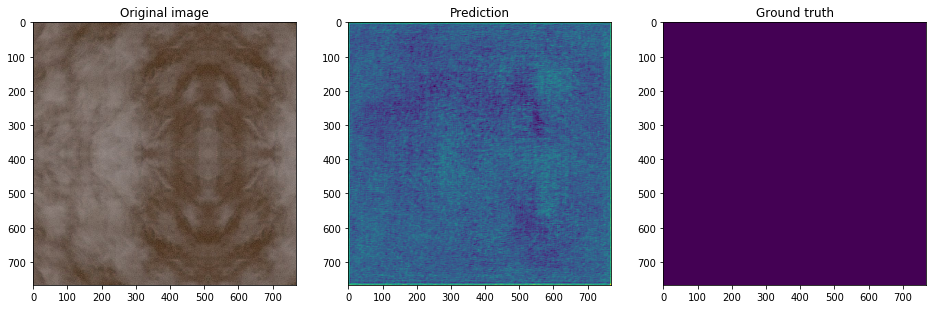

In [29]:
import matplotlib.pyplot as plt

for i in range(1):
    # read data
    batch = valid_gen.__next__()
    image = batch[0]
    gt_mask = batch[1].squeeze()

    # predicting
    mask = model.predict(image)

    # visualizing
    plt.figure(figsize=(16, 6))

    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image.squeeze())

    plt.subplot(132)
    plt.title('Prediction')
    plt.imshow(mask.squeeze().round(3))

    plt.subplot(133)
    plt.title('Ground truth')
    plt.imshow(gt_mask.squeeze())

    plt.show()